# Step.5 Modelling and Evaluation:

**Import Necessary libraries** 

In [3]:
# Gives time-related functions for calculating execution time
import time

import pandas as pd
import numpy as np

# To divide the dataset into training and testing subsets
from sklearn.model_selection import train_test_split

# Util to find to accurarcy score, classification report and confusion matrix
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# To balance data by creating synthetic samples for the minority class.
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_recall_fscore_support

# Visualizes the confusion matrix as a plot.
from sklearn.metrics import ConfusionMatrixDisplay as CM

# Standardized features by scaling them to have mean=0 and std=1
from sklearn.preprocessing import StandardScaler

## 5.1 Data Understanding:
Load the feature engineered data and check for quality and integrity.

In [5]:
# Read the dataset
df = pd.read_csv('Feature.csv')

# Store all the columns on which processing needs to be done in a variable
columns_to_keep = ['review_score','on_time_delivery',
                   'total_waiting_time',
                   'delivery_accuracy',
                   'logistics_time',
                   'is_review',
                   'late_early_arrival_time',
                   'same_state',
                   'distance_km',
                   'total_orders_per_seller',
                   'freight_value',
                   'payment_value' ]

# Keep only those columns defined above in the dataset
df = df[columns_to_keep]

# Convert review_score to binary (1 if score >= 4, else 0)
df['review_score'] = df['review_score'].apply(lambda x: 1 if x >= 4 else 0)

# Check for missing values
print(df.isnull().sum())

review_score               0
on_time_delivery           0
total_waiting_time         0
delivery_accuracy          0
logistics_time             0
is_review                  0
late_early_arrival_time    0
same_state                 0
distance_km                0
total_orders_per_seller    0
freight_value              0
payment_value              0
dtype: int64


## 5.2 Data Modelling:

### 5.2.1 Defining Input (x) and Output (y) Variables for Model Training:  
Set the data for x and y values, the x values are the ones on basis of which the model understands and predict y values.

In [8]:
# Set target and features
y_value = df['review_score']

# Change to array (list)
y_values = np.ravel(y_value)

# Drop the target column
X_values = df.drop('review_score', axis=1)

# Split data into training and testing datasets which is 80% and 20%
X_train, X_test, Y_train, Y_test = train_test_split(X_values, y_value, test_size=0.2, random_state=4567, stratify=y_value)

# Print the shapes to verify the data splitting
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(65451, 11)
(16363, 11)
(65451,)
(16363,)


### 5.2.2 Standardise Features

In [10]:
# Standardize the features for optimization of the model

# Create a StandardScaler instance to standardize features for optimal performance of the model
scaler = StandardScaler()

# Fit and transform the training set
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test set (using the training scaler)
X_test_scaled = scaler.transform(X_test)

### 5.2.3 Imbalanced data:

Balancing of the dataset using SMOTE(Synthetic Minority Ovesampling Technique)

In [13]:
# Oversampling Using SMOTE (on scaled data)
smote = SMOTE(random_state=42, sampling_strategy=1.0)

# Apply SMOTE on scaled data
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train_scaled, Y_train)

print(pd.Series(Y_train_resampled).value_counts())

review_score
1    51345
0    51345
Name: count, dtype: int64


**1. Using SMOTE**

In [15]:
# Define model with SMOTE

# Initialize a RandomForestClassifier with a fixed random state for reproducibility
# This classifier will be used on the dataset after applying SMOTE for oversampling
RF_algo_smote = RandomForestClassifier(random_state=42)

# Initialize a GradientBoostingClassifier with a fixed random state for reproducibility
# This classifier will be used on the dataset after applying SMOTE for oversampling
GBDT_algo_smote = GradientBoostingClassifier(random_state=42)

# Initialize a extremeGradientBoostingClassifier with a fixed random state for reproducibility
# This classifier will be used on the dataset after applying SMOTE for oversampling
XGB_algo_smote = XGBClassifier(random_state=42)

**2. Using Class Weight**

In [17]:
# Define model with Class Weight (balancing using class weight)
RF_algo_class_weight = RandomForestClassifier(class_weight='balanced', random_state=42)

# No direct class weights, SMOTE helps balance
GBDT_algo_class_weight = GradientBoostingClassifier()

# Initialize an XGBClassifier with a balanced class weights using parameter `scale_pos_weight`
# - `scale_pos_weight` is set to the ratio of the number of negative samples to positive samples in the training data
# This helps handle imbalanced datasets by giving more importance to the minority class
# - `random_state` ensures reproducibility of results
# - `eval_metric="logloss"` specifies the evaluation metric for the model, where log loss measures classification performance
XGB_algo_class_weight = XGBClassifier(
    scale_pos_weight=len(Y_train[Y_train == 0]) / len(Y_train[Y_train == 1]),
    random_state=42,
    eval_metric="logloss"
)

## 5.3 Training of the models:

### 5.3.1 Using SMOTE

**a. Random Forest**

In [21]:
# Training using scaled data for the SMOTE models

# Start time for SMOTE models to check for the performance
start_time = time.time()

# Train on scaled and resampled data
RF_model_smote = RF_algo_smote.fit(X_train_resampled, Y_train_resampled)
end_time = time.time()
training_time = end_time - start_time
print(f"Training Time (SMOTE - Random Forest): {training_time:.2f} seconds")

Training Time (SMOTE - Random Forest): 73.56 seconds


**b. Gradient Boosted**

In [23]:
# Start time for GBDT SMOTE
start_time = time.time()

# Train on scaled and resampled data
GBDT_model_smote = GBDT_algo_smote.fit(X_train_resampled, Y_train_resampled)

# End time for GBDT SMOTE
end_time = time.time()
training_time = end_time - start_time
print(f"Training Time (SMOTE - GBDT): {training_time:.2f} seconds")

Training Time (SMOTE - GBDT): 60.22 seconds


**c. exteme Gradient Boosted**

In [25]:
# Start time for XGB SMOTE
start_time = time.time()

# Train on SMOTE resampled data
XGB_model_smote = XGB_algo_smote.fit(X_train_resampled, Y_train_resampled)

# End time for XGB SMOTE
end_time = time.time()
training_time = end_time - start_time
print(f"Training Time (SMOTE - XGB): {training_time:.2f} seconds")

Training Time (SMOTE - XGB): 0.54 seconds


### 5.3.2  Using Class Weight

**a. Random Forest**

In [28]:
# Start time for Random Forest using Class Weight
start_time = time.time()

# Train using scaled data
RF_model_class_weight = RF_algo_class_weight.fit(X_train_scaled, Y_train)
end_time = time.time()
training_time = end_time - start_time
print(f"Training Time (Class Weight - Random Forest): {training_time:.2f} seconds")

Training Time (Class Weight - Random Forest): 33.20 seconds


**b. exteme Gradient Boosted**

In [30]:
# Start time for XGB Class Weight
start_time = time.time()

# Train using scaled data
XGB_model_class_weight = XGB_algo_class_weight.fit(X_train_scaled, Y_train)
end_time = time.time()
training_time = end_time - start_time
print(f"Training Time (Class Weight - XGB): {training_time:.2f} seconds")

Training Time (Class Weight - XGB): 0.46 seconds


## 5.4 Performance of the models:

In [32]:
# Store models and names for iteration
models_smote = [RF_model_smote, GBDT_model_smote, XGB_model_smote]
models_class_weight = [RF_model_class_weight, XGB_model_class_weight]
names = ['Random Forest', 'GBDT', 'XGBDT']

**Confusion matrices to visually see the performance of the the different models.**

Random Forest (SMOTE) Confusion Matrix
Random Forest (SMOTE) Classification Report
              precision    recall  f1-score   support

           0       0.54      0.35      0.43      3526
           1       0.84      0.92      0.88     12837

    accuracy                           0.80     16363
   macro avg       0.69      0.64      0.65     16363
weighted avg       0.77      0.80      0.78     16363

GBDT (SMOTE) Confusion Matrix
GBDT (SMOTE) Classification Report
              precision    recall  f1-score   support

           0       0.45      0.49      0.47      3526
           1       0.86      0.83      0.84     12837

    accuracy                           0.76     16363
   macro avg       0.65      0.66      0.66     16363
weighted avg       0.77      0.76      0.76     16363

XGBDT (SMOTE) Confusion Matrix
XGBDT (SMOTE) Classification Report
              precision    recall  f1-score   support

           0       0.60      0.31      0.41      3526
           1       0.8

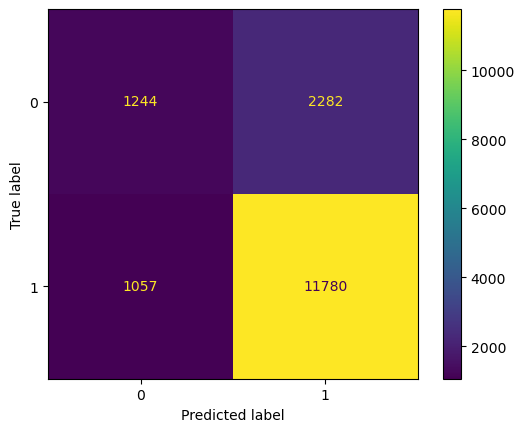

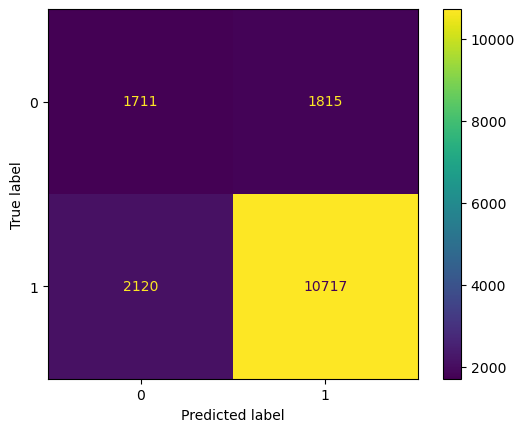

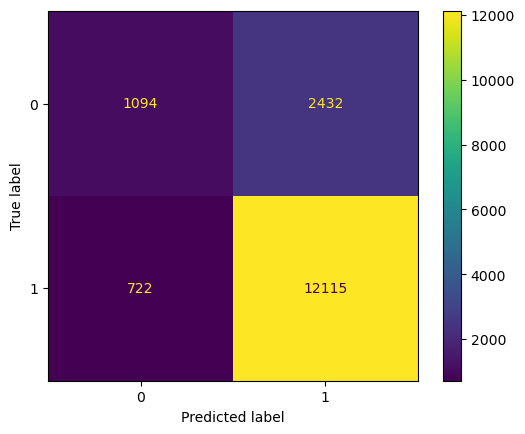

In [34]:
# Confusion Matrices and Classification Reports (using scaled features)

# Iterate through models (for SMOTE)
for model, name in zip(models_smote, names):
    print(f"{name} (SMOTE) Confusion Matrix")

    # Use scaled test data for prediction
    predict = model.predict(X_test_scaled)
    CM.from_predictions(Y_test, predict)
    print(f"{name} (SMOTE) Classification Report")
    print(classification_report(Y_test, predict))

Random Forest (Class Weight) Confusion Matrix
Random Forest (Class Weight) Classification Report
              precision    recall  f1-score   support

           0       0.72      0.25      0.37      3526
           1       0.82      0.97      0.89     12837

    accuracy                           0.82     16363
   macro avg       0.77      0.61      0.63     16363
weighted avg       0.80      0.82      0.78     16363

GBDT (Class Weight) Confusion Matrix
GBDT (Class Weight) Classification Report
              precision    recall  f1-score   support

           0       0.40      0.60      0.48      3526
           1       0.87      0.76      0.81     12837

    accuracy                           0.72     16363
   macro avg       0.64      0.68      0.65     16363
weighted avg       0.77      0.72      0.74     16363



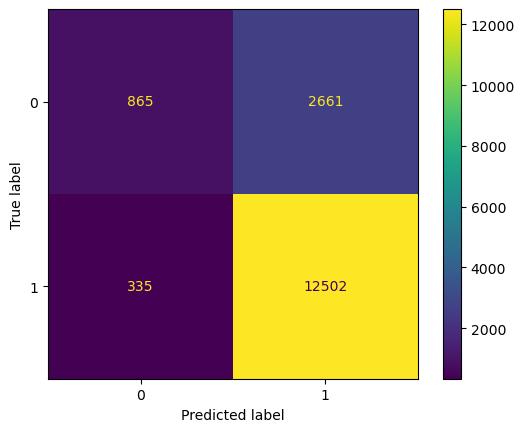

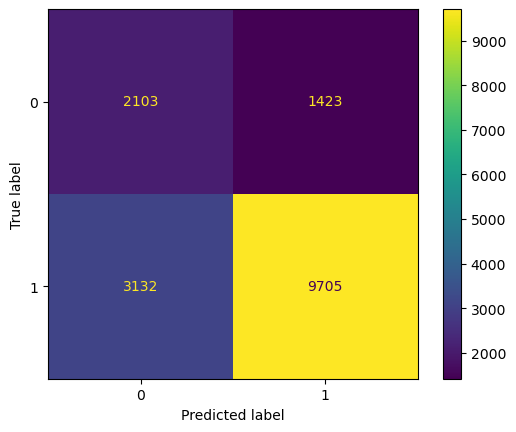

In [35]:
# Confusion Matrices and Classification Reports (using scaled features)

# Iterate through models (for Class Weight)
for model, name in zip(models_class_weight, names):
    print(f"{name} (Class Weight) Confusion Matrix")

    # Use scaled test data for prediction
    predict = model.predict(X_test_scaled)
    CM.from_predictions(Y_test, predict)
    print(f"{name} (Class Weight) Classification Report")
    print(classification_report(Y_test, predict))

## 5.5 Hyperparameter Tuning:
Hyperparameter tuning for Random Forest (Class Weight) using RandomizedSearchCV

In [37]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

In [38]:
# Define hyperparameters for tuning Random Forest
RF_tuned_parameters = {
    # Number of trees in the forest
    'n_estimators': randint(50, 300),
    # Maximum depth of the tree
    'max_depth': randint(2, 20),
    # Minimum samples required to split an internal node
    'min_samples_split': randint(2, 10),
    # Minimum samples required to be at a leaf node
    'min_samples_leaf': randint(1, 5),
     # Number of features considered at each split
    'max_features': ['sqrt', 'log2', None],
    # Whether bootstrap samples are used when building trees
    'bootstrap': [True, False]
}

# Initialize Random Forest model (with class weight)
RF_algo_class_weight = RandomForestClassifier(class_weight='balanced', random_state=42)

# Set up the RandomizedSearchCV to find the best hyperparameters
clf_rf_class_weight = RandomizedSearchCV(
    RF_algo_class_weight,
    RF_tuned_parameters,
    cv=3,  # 3-fold cross-validation
    verbose=1,  # Print progress during the search
    scoring='f1_macro',  # Optimize for F1-Score
    n_iter=10,  # Number of parameter settings sampled
    n_jobs=-1,  # Use all cores for faster computation
    random_state=2015
)


In [39]:
# Perform the RandomizedSearchCV fitting using scaled training data
start_time = time.time()
clf_rf_class_weight.fit(X_train_scaled, Y_train)
end_time = time.time()

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [40]:
# Display the best parameters found
print(f"Best Hyperparameters for Random Forest (Class Weight): {clf_rf_class_weight.best_params_}")
print(f"Hyperparameter Tuning Time: {end_time - start_time:.2f} seconds")


Best Hyperparameters for Random Forest (Class Weight): {'bootstrap': False, 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 104}
Hyperparameter Tuning Time: 326.95 seconds


## 5.6 Train the model:
Retrain the model with best parameters found

In [42]:
# Train Random Forest model with the best parameters found

# Get the best model with tuned hyperparameters
best_rf_class_weight = clf_rf_class_weight.best_estimator_

# Train the final model on the entire training set (using best hyperparameters)
best_rf_class_weight.fit(X_train_scaled, Y_train)

RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=4,
                       max_features='log2', min_samples_leaf=3,
                       min_samples_split=8, n_estimators=104, random_state=42)

## 5.7 Evaluation of the model:

In [44]:
# Evaluate the tuned Random Forest model on the test set

# Predict on the test set
# Use scaled test data for prediction
predict_rf_class_weight = best_rf_class_weight.predict(X_test_scaled)

Random Forest (Class Weight) Confusion Matrix
Random Forest (Class Weight) Classification Report (Test Data)
              precision    recall  f1-score   support

           0       0.42      0.54      0.47      3526
           1       0.86      0.80      0.83     12837

    accuracy                           0.74     16363
   macro avg       0.64      0.67      0.65     16363
weighted avg       0.77      0.74      0.75     16363

Macro Precision: 0.64
Macro Recall: 0.67
Macro F1-score: 0.65


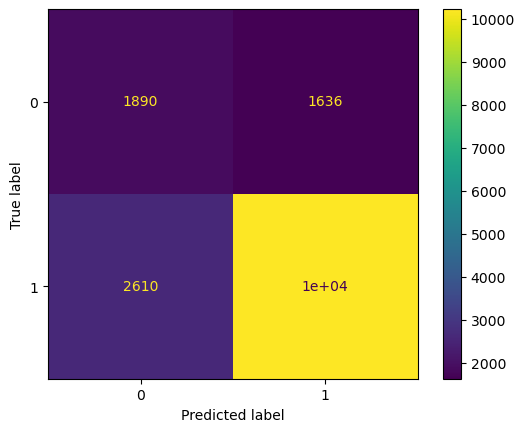

In [45]:
# Confusion Matrix for Random Forest model
print("Random Forest (Class Weight) Confusion Matrix")
CM.from_predictions(Y_test, predict_rf_class_weight)

# Classification Report for Random Forest model
print("Random Forest (Class Weight) Classification Report (Test Data)")
print(classification_report(Y_test, predict_rf_class_weight))

#%% Calculate and print precision, recall, and F1-score (Macro)
precision, recall, f1_score, _ = precision_recall_fscore_support(Y_test, predict_rf_class_weight, average='macro')
print(f"Macro Precision: {precision:.2f}")
print(f"Macro Recall: {recall:.2f}")
print(f"Macro F1-score: {f1_score:.2f}")